In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import pickle

In [4]:
MNM_nb_folder = os.path.join('..', '..', '..', 'side_project', 'network_builder')
sys.path.append(MNM_nb_folder)
python_lib_folder = os.path.join('..', '..', 'pylib')
sys.path.append(python_lib_folder)

In [6]:
from MNM_nb import *
import MNMAPI
from sDODE import *
from covariance_tree import *

/home/lemma/.conda/envs/python2/lib/python2.7/site-packages/bidict/compat.py:33: UserWarning: Python 2 support will be dropped in a future release.
  warn('Python 2 support will be dropped in a future release.')


In [7]:
data_folder = os.path.join('..', '..', '..', 'data', 'input_files_33net')

In [8]:
nb = MNM_network_builder()
nb.load_from_folder(data_folder)
O_dist = np.arange(3)
D_dist = np.arange(3)
usefuk_link_list = list(filter(lambda x: x.typ == 'CTM', nb.link_list))

MNM_config
MNM_pathtable


In [9]:
len(usefuk_link_list)

24

In [10]:
num_observed_links = 12

In [11]:
config = dict()

config['use_link_flow'] = True
config['use_link_tt'] = False
config['link_flow_weight'] = 1
config['link_tt_weight'] = 1
config['num_data'] = 10
config['observed_links'] = list(map(lambda x: x.ID, np.random.choice(usefuk_link_list, num_observed_links)))
config['paths_list'] = list(range(nb.config.config_dict['FIXED']['num_path']))

In [12]:
num_interval = nb.config.config_dict['DTA']['max_interval']
theta = 0.01

In [13]:
sdode = SDODE(nb, config)
# true_q = sdode.init_demand_flow(init_scale = 50)
true_q_para = OD_parameter_server(sdode.demand_list, sdode.num_assign_interval)
true_q_para.construct(O_dist, D_dist)
true_q_para.initialize(mean_scale = 20, std_scale= 0, 
                        O_cov_scale = 0, D_cov_scale = 0)
# true_q_para = pickle.load(open('potential_true_q.pickle', 'rb'))
true_q = np.concatenate(true_q_para.demand_mean_list)
old_f = np.zeros(num_interval * len(config['paths_list']))
num_iters = 50
P = sdode.nb.get_route_portion_matrix()
true_f = P.dot(true_q)
for i in range(num_iters):
    dta = sdode._run_simulation(true_f)
    path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))
    sdode.assign_route_portions(path_cost, theta = theta)
    new_f = sdode.nb.get_route_portion_matrix().dot(true_q)
    true_f = np.float(i) / np.float(i+1) * true_f + np.float(1) / np.float(i+1) * new_f
#     print np.linalg.norm(true_f - old_f)
    old_f = true_f
    sdode.nb.update_demand_path(new_f)

In [14]:
assert (np.isclose(true_q.sum(), true_f.sum()))

In [15]:
dta = sdode._run_simulation(true_f)
true_P = sdode.nb.get_route_portion_matrix()
true_full_dar = sdode.get_full_dar(dta, true_f)
true_dar = true_full_dar[sdode.get_full_observed_link_index(),:]
full_true_x = true_full_dar.dot(true_f)
true_x = true_dar.dot(true_f)
true_path_cost = dta.get_path_tt(np.arange(0, sdode.num_loading_interval, sdode.ass_freq))

In [16]:
num_data = config['num_data']
data_dict = dict()
data_dict['link_flow'] = list()
sdode = SDODE(nb, config)
for i in range(config['num_data']):
    q_e, _ = true_q_para.forward()
    f_e = true_P.dot(q_e)
    dta = sdode._run_simulation(f_e)
    full_dar_e = sdode.get_full_dar(dta, f_e)
    dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
    x_e = dar_e.dot(f_e)
    link_df = pd.DataFrame(index = range(num_interval), columns = config['observed_links'], 
                           data = x_e.reshape((num_interval, len(config['observed_links']))) 
                               + np.random.randn(num_interval, len(config['observed_links'])) * 0.0)
    data_dict['link_flow'].append(link_df)

In [21]:
# q_e, _ = q_para.forward()
# f_e = true_P.dot(q_e)
# dta = sdode._run_simulation(f_e)
# full_dar_e = sdode.get_full_dar(dta, f_e)
# dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
# x_e = dar_e.dot(f_e)
# full_x_e = full_dar_e.dot(f_e)

In [22]:
# plt.figure(figsize = (16,9))
# plt.scatter(full_x_e, full_true_x)
# plt.scatter(x_e, true_x, color = 'red')
# plt.plot(full_x_e,full_x_e)
# plt.show()

In [23]:
x_e

array([ 3.2, 10.4, 21.8,  5.6, 21.8, 10.4,  0. ,  0. ,  6. , 15.6,  5.6,
       15.2,  8.6, 23.2, 25.2,  4.6, 25.2, 23.2,  0. ,  5.8, 12.4, 15.8,
        4.6, 17. , 25. , 29.8, 40.8,  6.4, 40.8, 29.8,  0. , 16.4, 15.6,
       16.2,  6.4, 20.8, 18. , 29.8, 29.2,  7. , 29.2, 29.8,  0. , 14.4,
       18.6, 17. ,  7. , 11.4, 22.2, 38.2, 26. ,  5.8, 26. , 38.2,  0. ,
       15.4, 13.8, 22.2,  5.8,  2. , 19. , 26.8, 37.2,  9.6, 37.2, 26.8,
        0. , 16.4, 17. , 19.6,  9.6, 10.8, 19.2, 38.6, 32.4,  8. , 32.4,
       38.6,  0. , 12.6, 17.2, 27. ,  8. ,  5.8, 22.6, 34.2, 46.4,  6.6,
       46.4, 34.2,  0. , 16.2, 20. , 23.2,  6.6, 13. , 22.8, 37.6, 25.2,
        6.2, 25.2, 37.6,  0. , 18. , 16.6, 18.4,  6.2,  2.2, 25.2, 31.4,
       35.2,  3.6, 35.2, 31.4,  0. , 18.4, 10.2, 11.2,  3.6, 11.8])

In [24]:
true_x

array([ 5.4, 10.4, 20.6,  5. , 20.6, 10.4,  0. ,  0. ,  9. , 15.8,  5. ,
       17.8, 10.6, 24.2, 30.6,  3. , 30.6, 24.2,  0. ,  6.4, 11.6, 21. ,
        3. , 15.2, 23.2, 30.4, 43.4,  4.6, 43.4, 30.4,  0. , 13.8, 16.2,
       13.6,  4.6, 19.2, 16.4, 29. , 21.8,  8.2, 21.8, 29. ,  0. , 14.8,
       21. , 12. ,  8.2, 12.8, 23.6, 41.6, 22.6,  4. , 22.6, 41.6,  0. ,
       20.2, 13.6, 19.6,  4. ,  2.8, 19.4, 28.8, 32.6,  6.8, 32.6, 28.8,
        0. , 16.6, 18.2, 18.4,  6.8, 12.2, 17.2, 35.2, 33. ,  8.6, 33. ,
       35.2,  0. , 10.6, 16.8, 28.4,  8.6,  5.4, 22.2, 31.8, 48.4,  6.2,
       48.4, 31.8,  0. , 16.8, 16. , 23.8,  6.2, 13. , 18.6, 34. , 25. ,
        5.6, 25. , 34. ,  0. , 16.6, 17.6, 20. ,  5.6,  3.4, 23.4, 28. ,
       35.4,  2.4, 35.4, 28. ,  0. , 19.2, 10. , 13.6,  2.4, 13.2])

In [25]:
sdode.add_data(data_dict)

In [26]:
print "Start sovling"
q_para, loss_list1 = sdode.estimate_demand_cov(O_dist, D_dist, init_mean_scale = 1, 
                      init_std_scale = 0.1, init_O_cov_scale = 0.1,
                      init_D_cov_scale = 0.1, step_size = 1, theta = theta, max_epoch = 100,
                                  adagrad = True, known_path_cost = true_path_cost)

Start sovling
Epoch: 0 Loss: 166.44776647350528
Epoch: 1 Loss: 110.8775526448107
Epoch: 2 Loss: 85.96738182341885
Epoch: 3 Loss: 68.8501521388011
Epoch: 4 Loss: 57.315598380048826
Epoch: 5 Loss: 51.21502720090857
Epoch: 6 Loss: 47.07481948854128
Epoch: 7 Loss: 44.93553907061354
Epoch: 8 Loss: 42.889841514049614
Epoch: 9 Loss: 42.192929375902075
Epoch: 10 Loss: 41.084255656488374
Epoch: 11 Loss: 39.41130248915031
Epoch: 12 Loss: 37.17967996248826
Epoch: 13 Loss: 38.304963331636735
Epoch: 14 Loss: 35.010156079164794
Epoch: 15 Loss: 36.0053989021201
Epoch: 16 Loss: 34.312565586069674
Epoch: 17 Loss: 36.149969156191055
Epoch: 18 Loss: 34.554065322224076
Epoch: 19 Loss: 33.990859656980575
Epoch: 20 Loss: 33.237033791046045
Epoch: 21 Loss: 35.06225044347766
Epoch: 22 Loss: 33.08066638018206
Epoch: 23 Loss: 32.97123804667429
Epoch: 24 Loss: 32.01445062553861
Epoch: 25 Loss: 32.71652880420298
Epoch: 26 Loss: 31.866354802174975
Epoch: 27 Loss: 31.994585347948494
Epoch: 28 Loss: 30.5309615939274

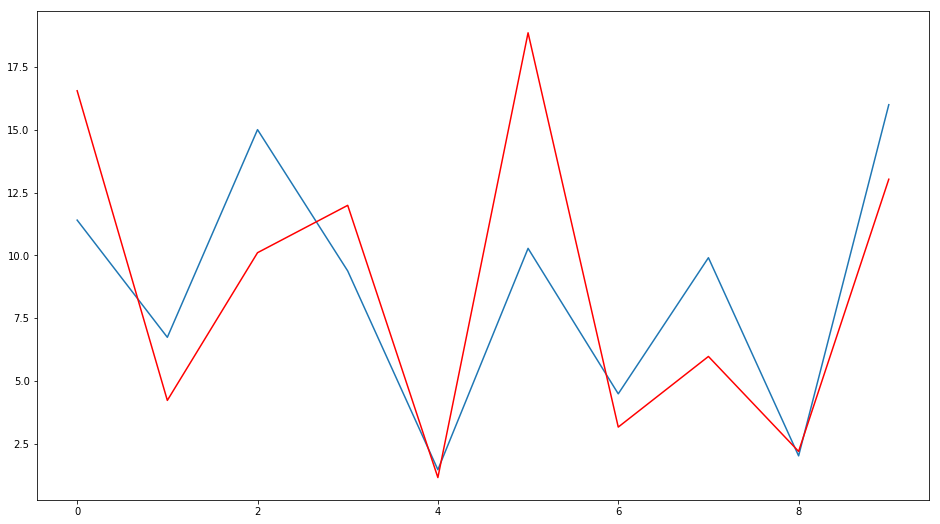

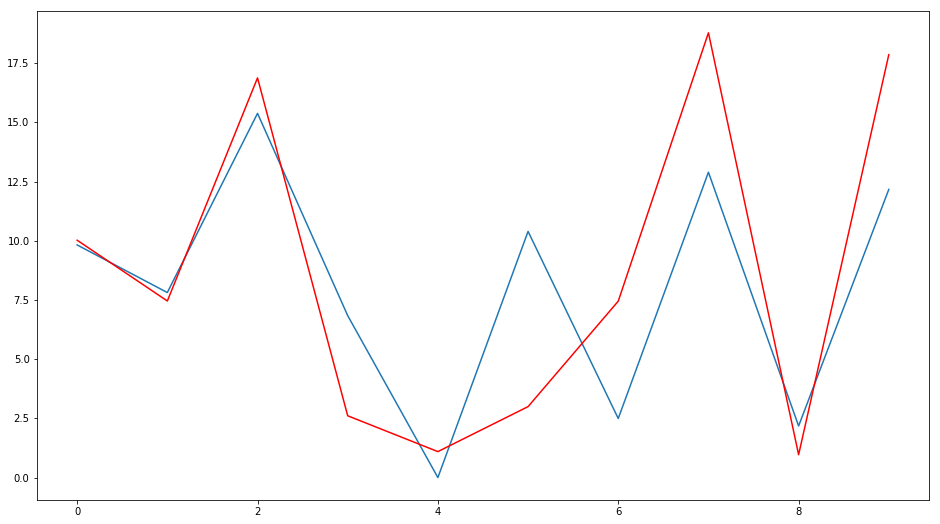

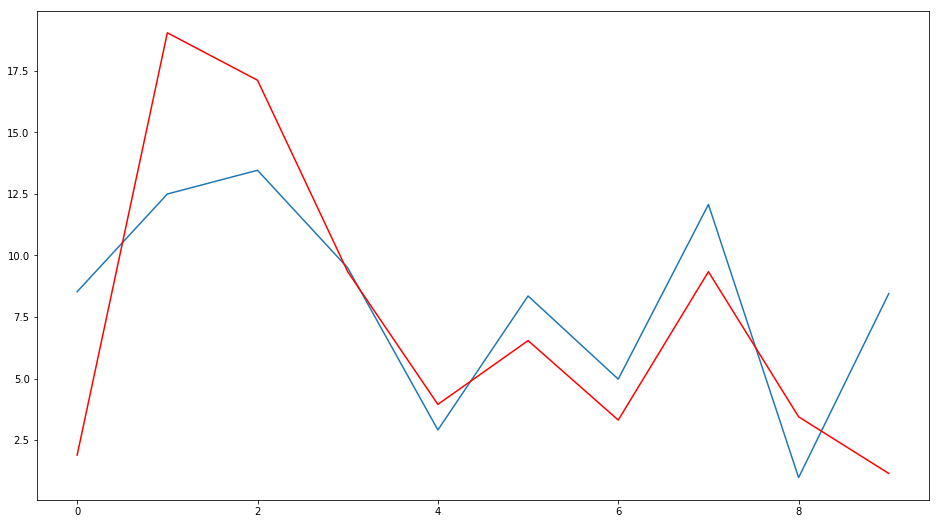

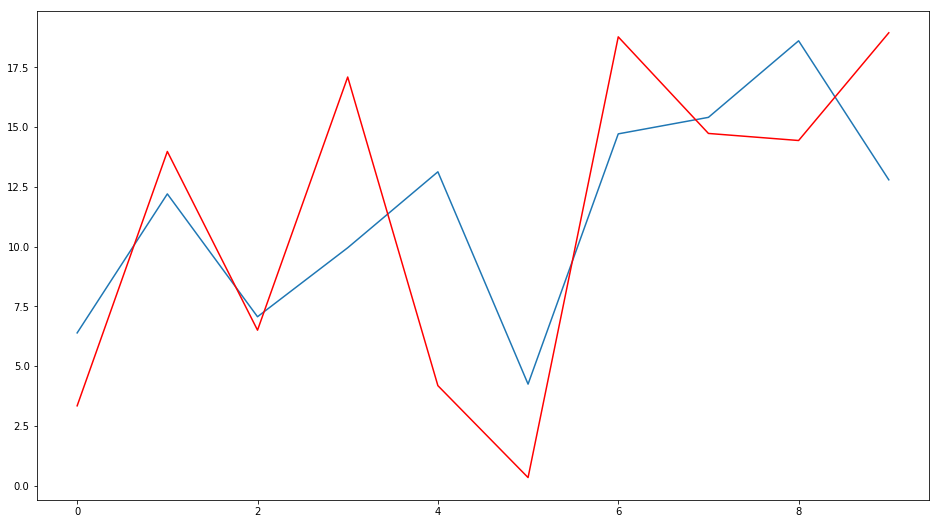

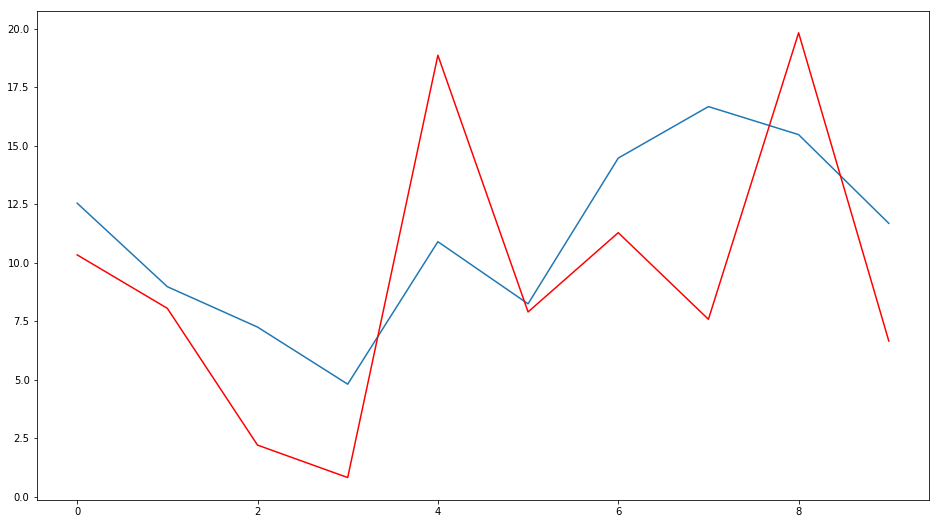

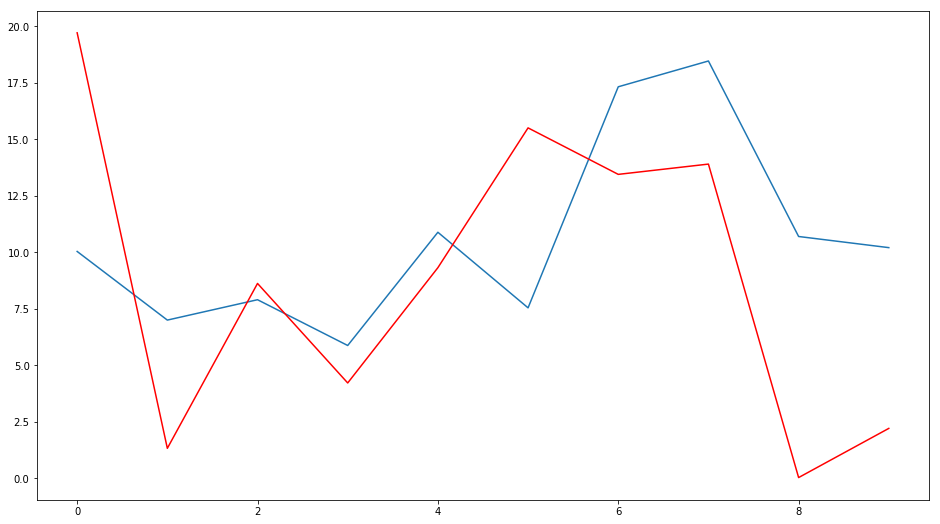

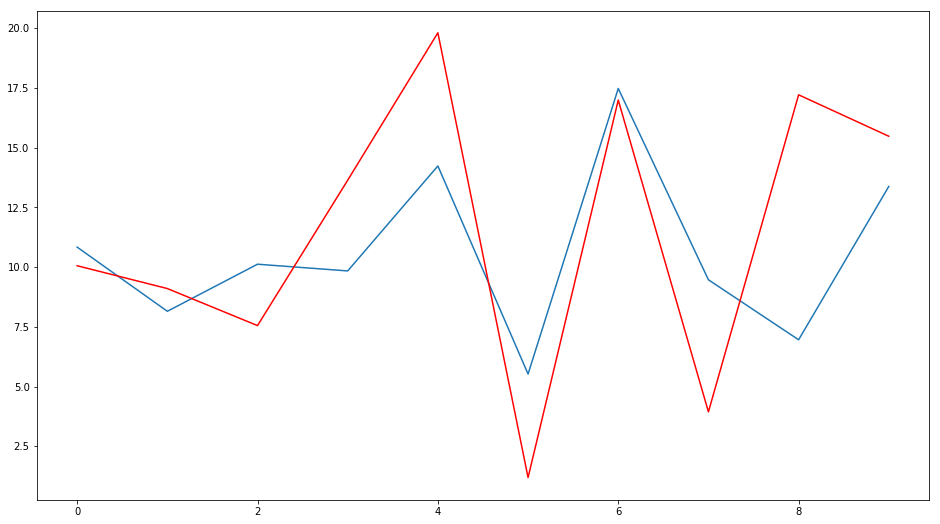

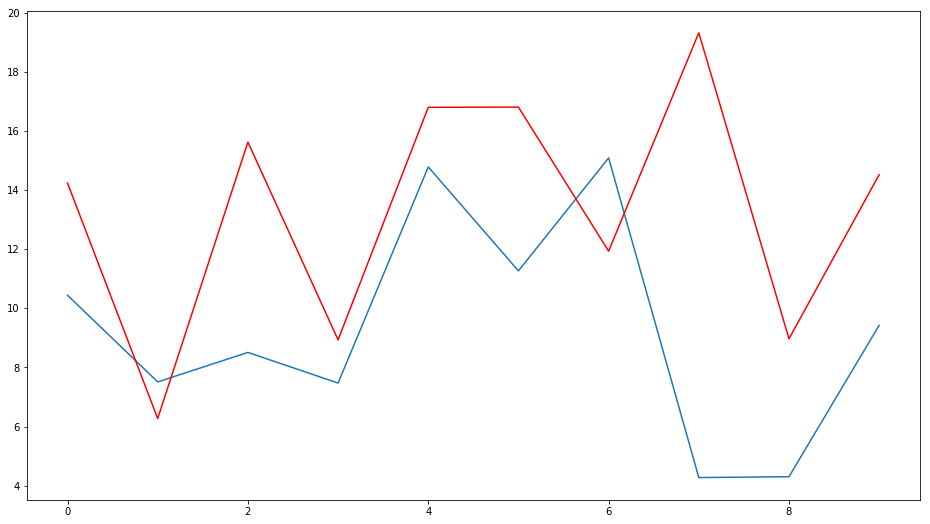

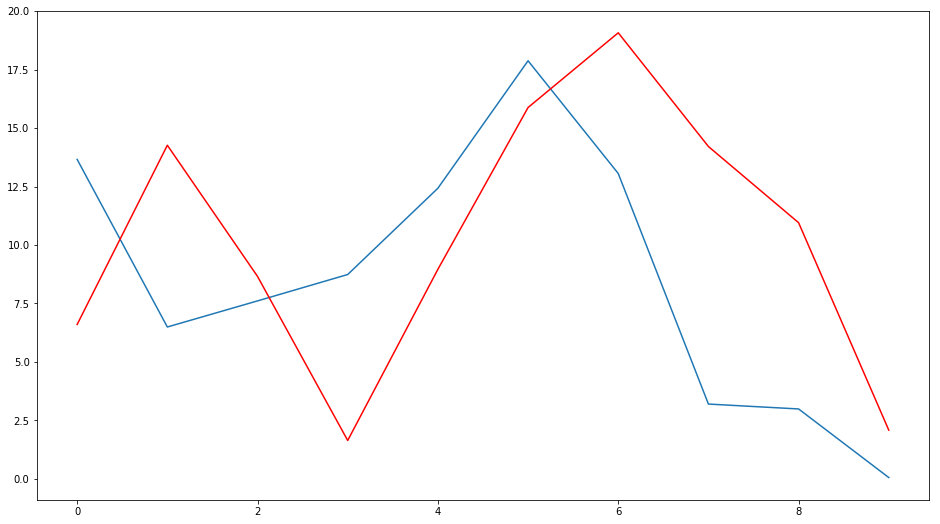

In [27]:
for i in range(9):
    plt.figure(figsize = (16,9))
    plt.plot(np.concatenate(q_para.demand_mean_list).reshape(-1, 9)[:, i])
    plt.plot(np.concatenate(true_q_para.demand_mean_list).reshape(-1, 9)[:, i], color = 'red')
    plt.show()

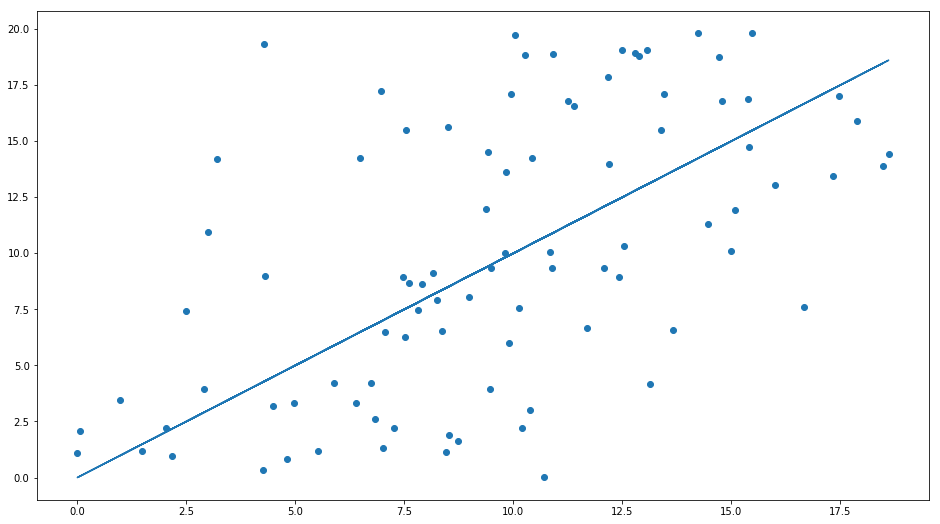

In [28]:
plt.figure(figsize = (16,9))
plt.scatter(np.concatenate(q_para.demand_mean_list), np.concatenate(true_q_para.demand_mean_list))
plt.plot(np.concatenate(q_para.demand_mean_list),np.concatenate(q_para.demand_mean_list))
plt.show()

In [29]:
np.concatenate(q_para.demand_mean_list).reshape(-1, 3)

array([[1.14037453e+01, 9.82127548e+00, 8.52892388e+00],
       [6.39347131e+00, 1.25465699e+01, 1.00427005e+01],
       [1.08378168e+01, 1.04406259e+01, 1.36588392e+01],
       [6.74315701e+00, 7.81168913e+00, 1.24967282e+01],
       [1.22070080e+01, 8.97791855e+00, 7.00473102e+00],
       [8.15185505e+00, 7.51049448e+00, 6.49301474e+00],
       [1.50020305e+01, 1.53767117e+01, 1.34617255e+01],
       [7.06933906e+00, 7.25316201e+00, 7.90659840e+00],
       [1.01229887e+01, 8.50781831e+00, 7.60879362e+00],
       [9.38241794e+00, 6.83771584e+00, 9.49718744e+00],
       [9.95468034e+00, 4.81237881e+00, 5.88047828e+00],
       [9.84194570e+00, 7.47080979e+00, 8.73698978e+00],
       [1.47794838e+00, 1.00000000e-06, 2.91282046e+00],
       [1.31314951e+01, 1.09010507e+01, 1.08922129e+01],
       [1.42371584e+01, 1.47813472e+01, 1.24264399e+01],
       [1.02799078e+01, 1.03925114e+01, 8.35546520e+00],
       [4.25070868e+00, 8.24539052e+00, 7.54693519e+00],
       [5.52365516e+00, 1.12660

In [30]:
np.concatenate(true_q_para.demand_mean_list).reshape(-1, 3)

array([[16.54771458, 10.0205616 ,  1.89292343],
       [ 3.34334959, 10.3378406 , 19.7199228 ],
       [10.05909599, 14.23328128,  6.60113053],
       [ 4.23448515,  7.45514461, 19.04575343],
       [13.98193705,  8.05309566,  1.32966072],
       [ 9.10373208,  6.27243559, 14.26459299],
       [10.10741369, 16.87520215, 17.11848189],
       [ 6.5073497 ,  2.20919042,  8.62669969],
       [ 7.55274375, 15.62231668,  8.65624773],
       [11.99099691,  2.60852561,  9.34254471],
       [17.09602805,  0.82179168,  4.22258108],
       [13.64054824,  8.93308495,  1.64016849],
       [ 1.16587167,  1.09594327,  3.95116625],
       [ 4.18710799, 18.86816275,  9.32461429],
       [19.81225063, 16.79796645,  8.95971122],
       [18.8523918 ,  2.99467281,  6.54207491],
       [ 0.34258744,  7.89831427, 15.51190128],
       [ 1.18976328, 16.80585425, 15.87832117],
       [ 3.17331374,  7.447461  ,  3.31460064],
       [18.77579622, 11.28574254, 13.45409309],
       [16.99565002, 11.93270421, 19.073

In [31]:
q_ee = np.concatenate(q_para.demand_mean_list)
P_ee = sdode.nb.get_route_portion_matrix()
f_ee = P_ee.dot(q_ee)
dta = sdode._run_simulation(f_ee)
full_dar_ee = sdode.get_full_dar(dta, f_ee)
dar_ee = full_dar_ee[sdode.get_full_observed_link_index(),:]
x_ee = dar_ee.dot(f_ee)

In [32]:
print "Start sovling"
q_e, loss_list2 = sdode.estimate_demand(init_scale = 0.1, step_size = 0.2, 
                      max_epoch = 100, adagrad = True,
                      theta = theta)

Start sovling
Epoch: 0 Loss: 224.33954896199165
Epoch: 1 Loss: 209.412177811102
Epoch: 2 Loss: 189.96549553191937
Epoch: 3 Loss: 169.75131229712468
Epoch: 4 Loss: 148.72837814370692
Epoch: 5 Loss: 127.81839088002293
Epoch: 6 Loss: 108.64234070802738
Epoch: 7 Loss: 88.43331493368191
Epoch: 8 Loss: 73.27226350986952
Epoch: 9 Loss: 59.655108132960194
Epoch: 10 Loss: 48.84706653901675
Epoch: 11 Loss: 44.4091454184922
Epoch: 12 Loss: 41.87279895302154
Epoch: 13 Loss: 37.615123681788745
Epoch: 14 Loss: 36.42753857180786
Epoch: 15 Loss: 34.07049579888795
Epoch: 16 Loss: 34.05567656513559
Epoch: 17 Loss: 32.99308553490967
Epoch: 18 Loss: 30.83006862778753
Epoch: 19 Loss: 33.23615462024108
Epoch: 20 Loss: 31.59328759682049
Epoch: 21 Loss: 32.454513864216494
Epoch: 22 Loss: 33.294614325260454
Epoch: 23 Loss: 34.239336104879065
Epoch: 24 Loss: 32.70047399970783
Epoch: 25 Loss: 31.75779885533288
Epoch: 26 Loss: 32.24764099468068
Epoch: 27 Loss: 31.708060279514115
Epoch: 28 Loss: 33.059934985436726

In [33]:
P_e = sdode.nb.get_route_portion_matrix()
f_e = P_e.dot(q_e)
dta = sdode._run_simulation(f_e)
full_dar_e = sdode.get_full_dar(dta, f_e)
dar_e = full_dar_e[sdode.get_full_observed_link_index(),:]
x_e = dar_e.dot(f_e)

In [34]:
plt.style.use('seaborn-poster')

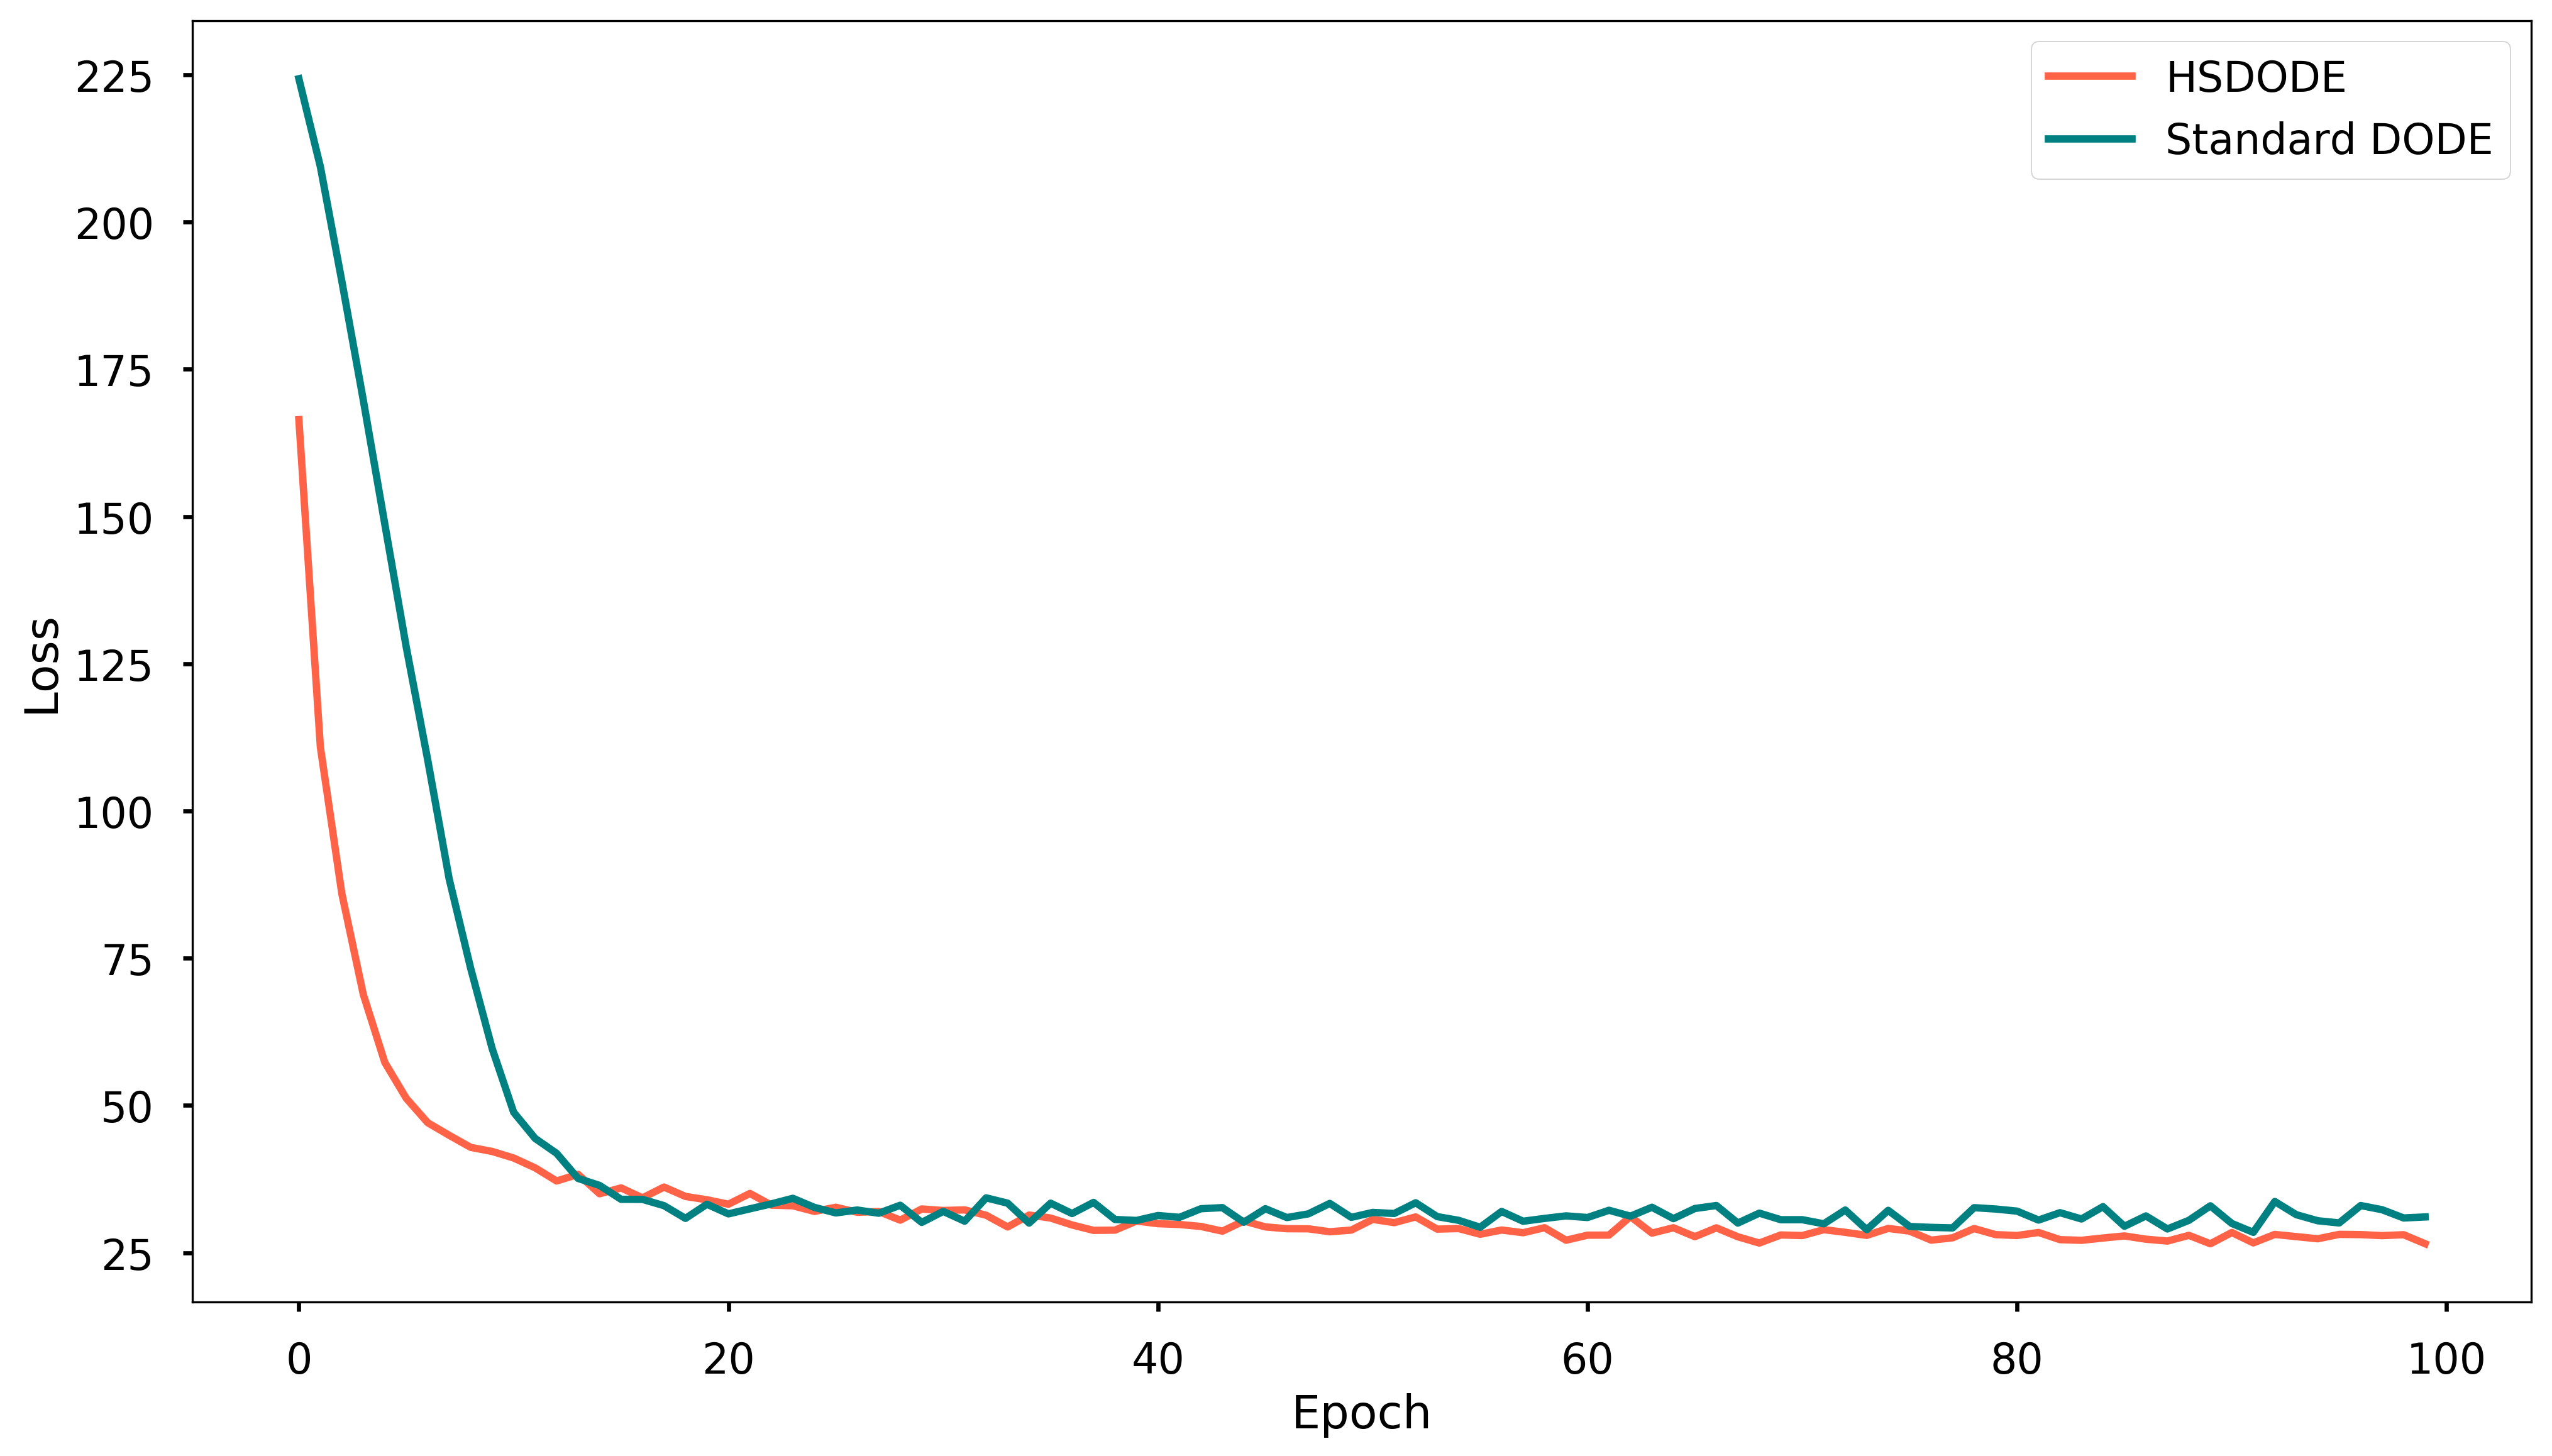

In [35]:
plt.figure(figsize = (16,9), dpi = 300)
plt.plot(loss_list1, label = 'HSDODE', color = 'tomato')
plt.plot(loss_list2, label = 'Standard DODE', color = 'teal')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.show()

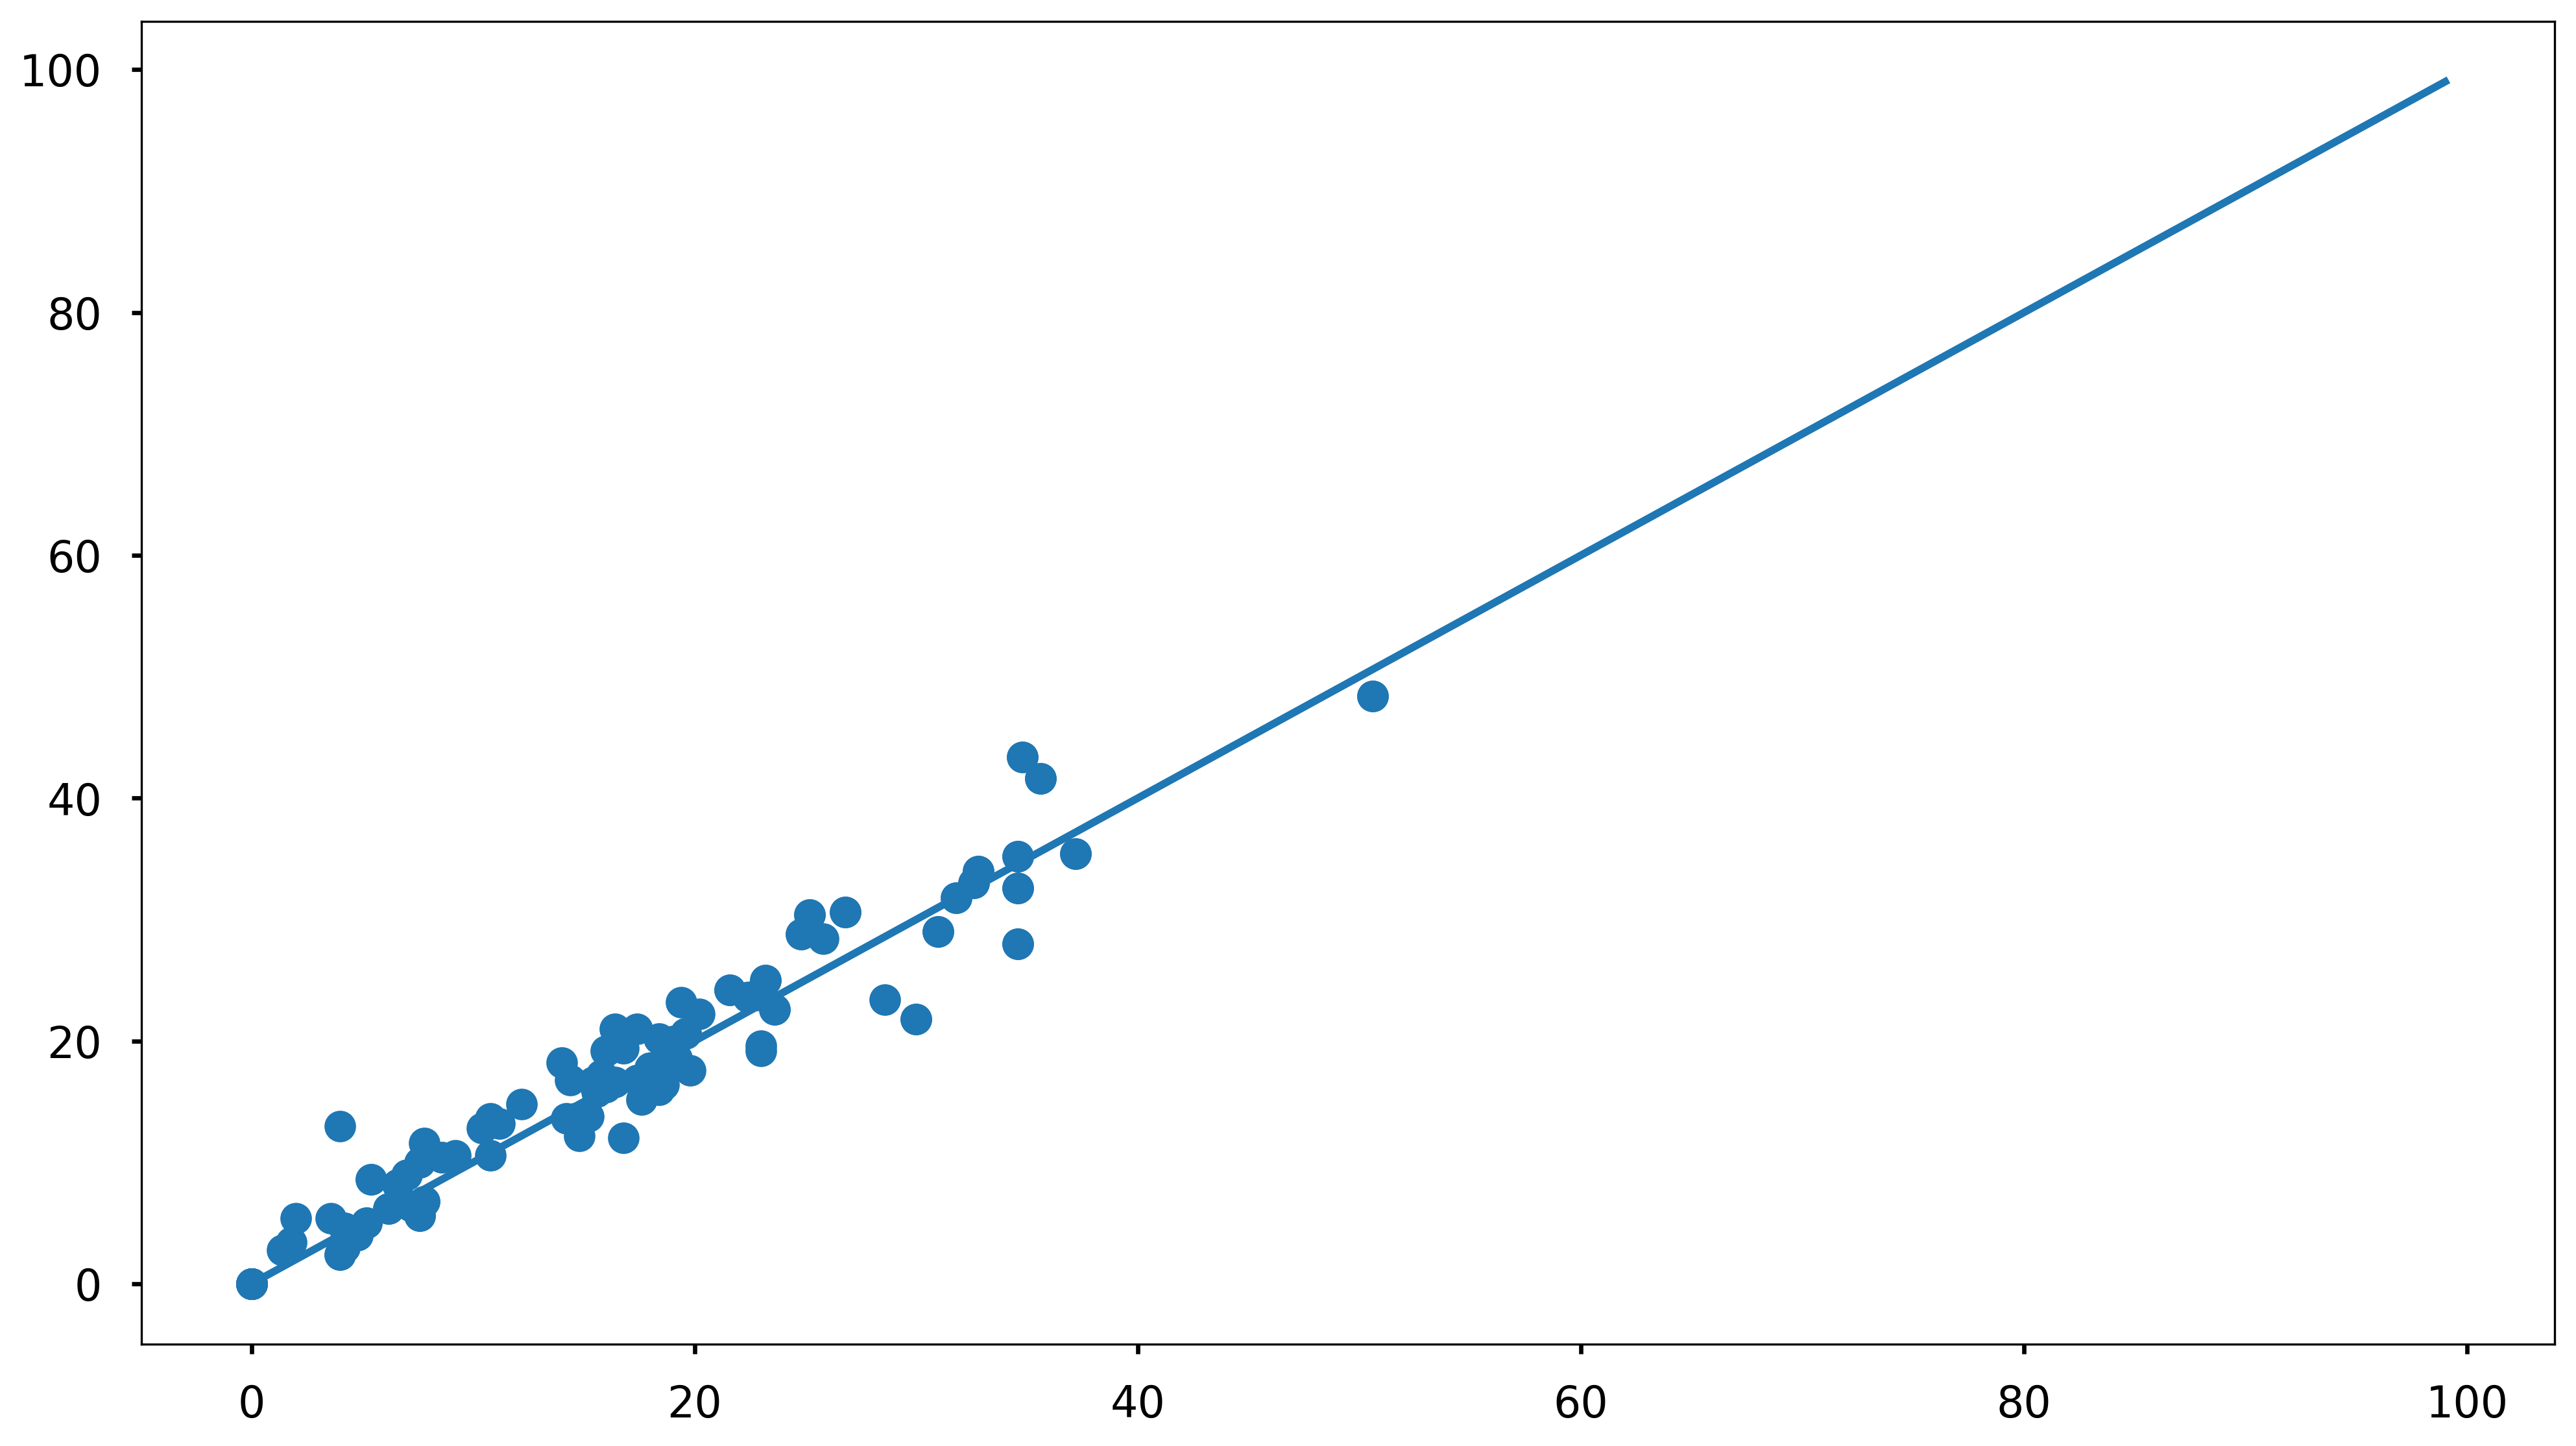

In [36]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_e, true_x)
plt.plot(range(100), range(100))
plt.show()

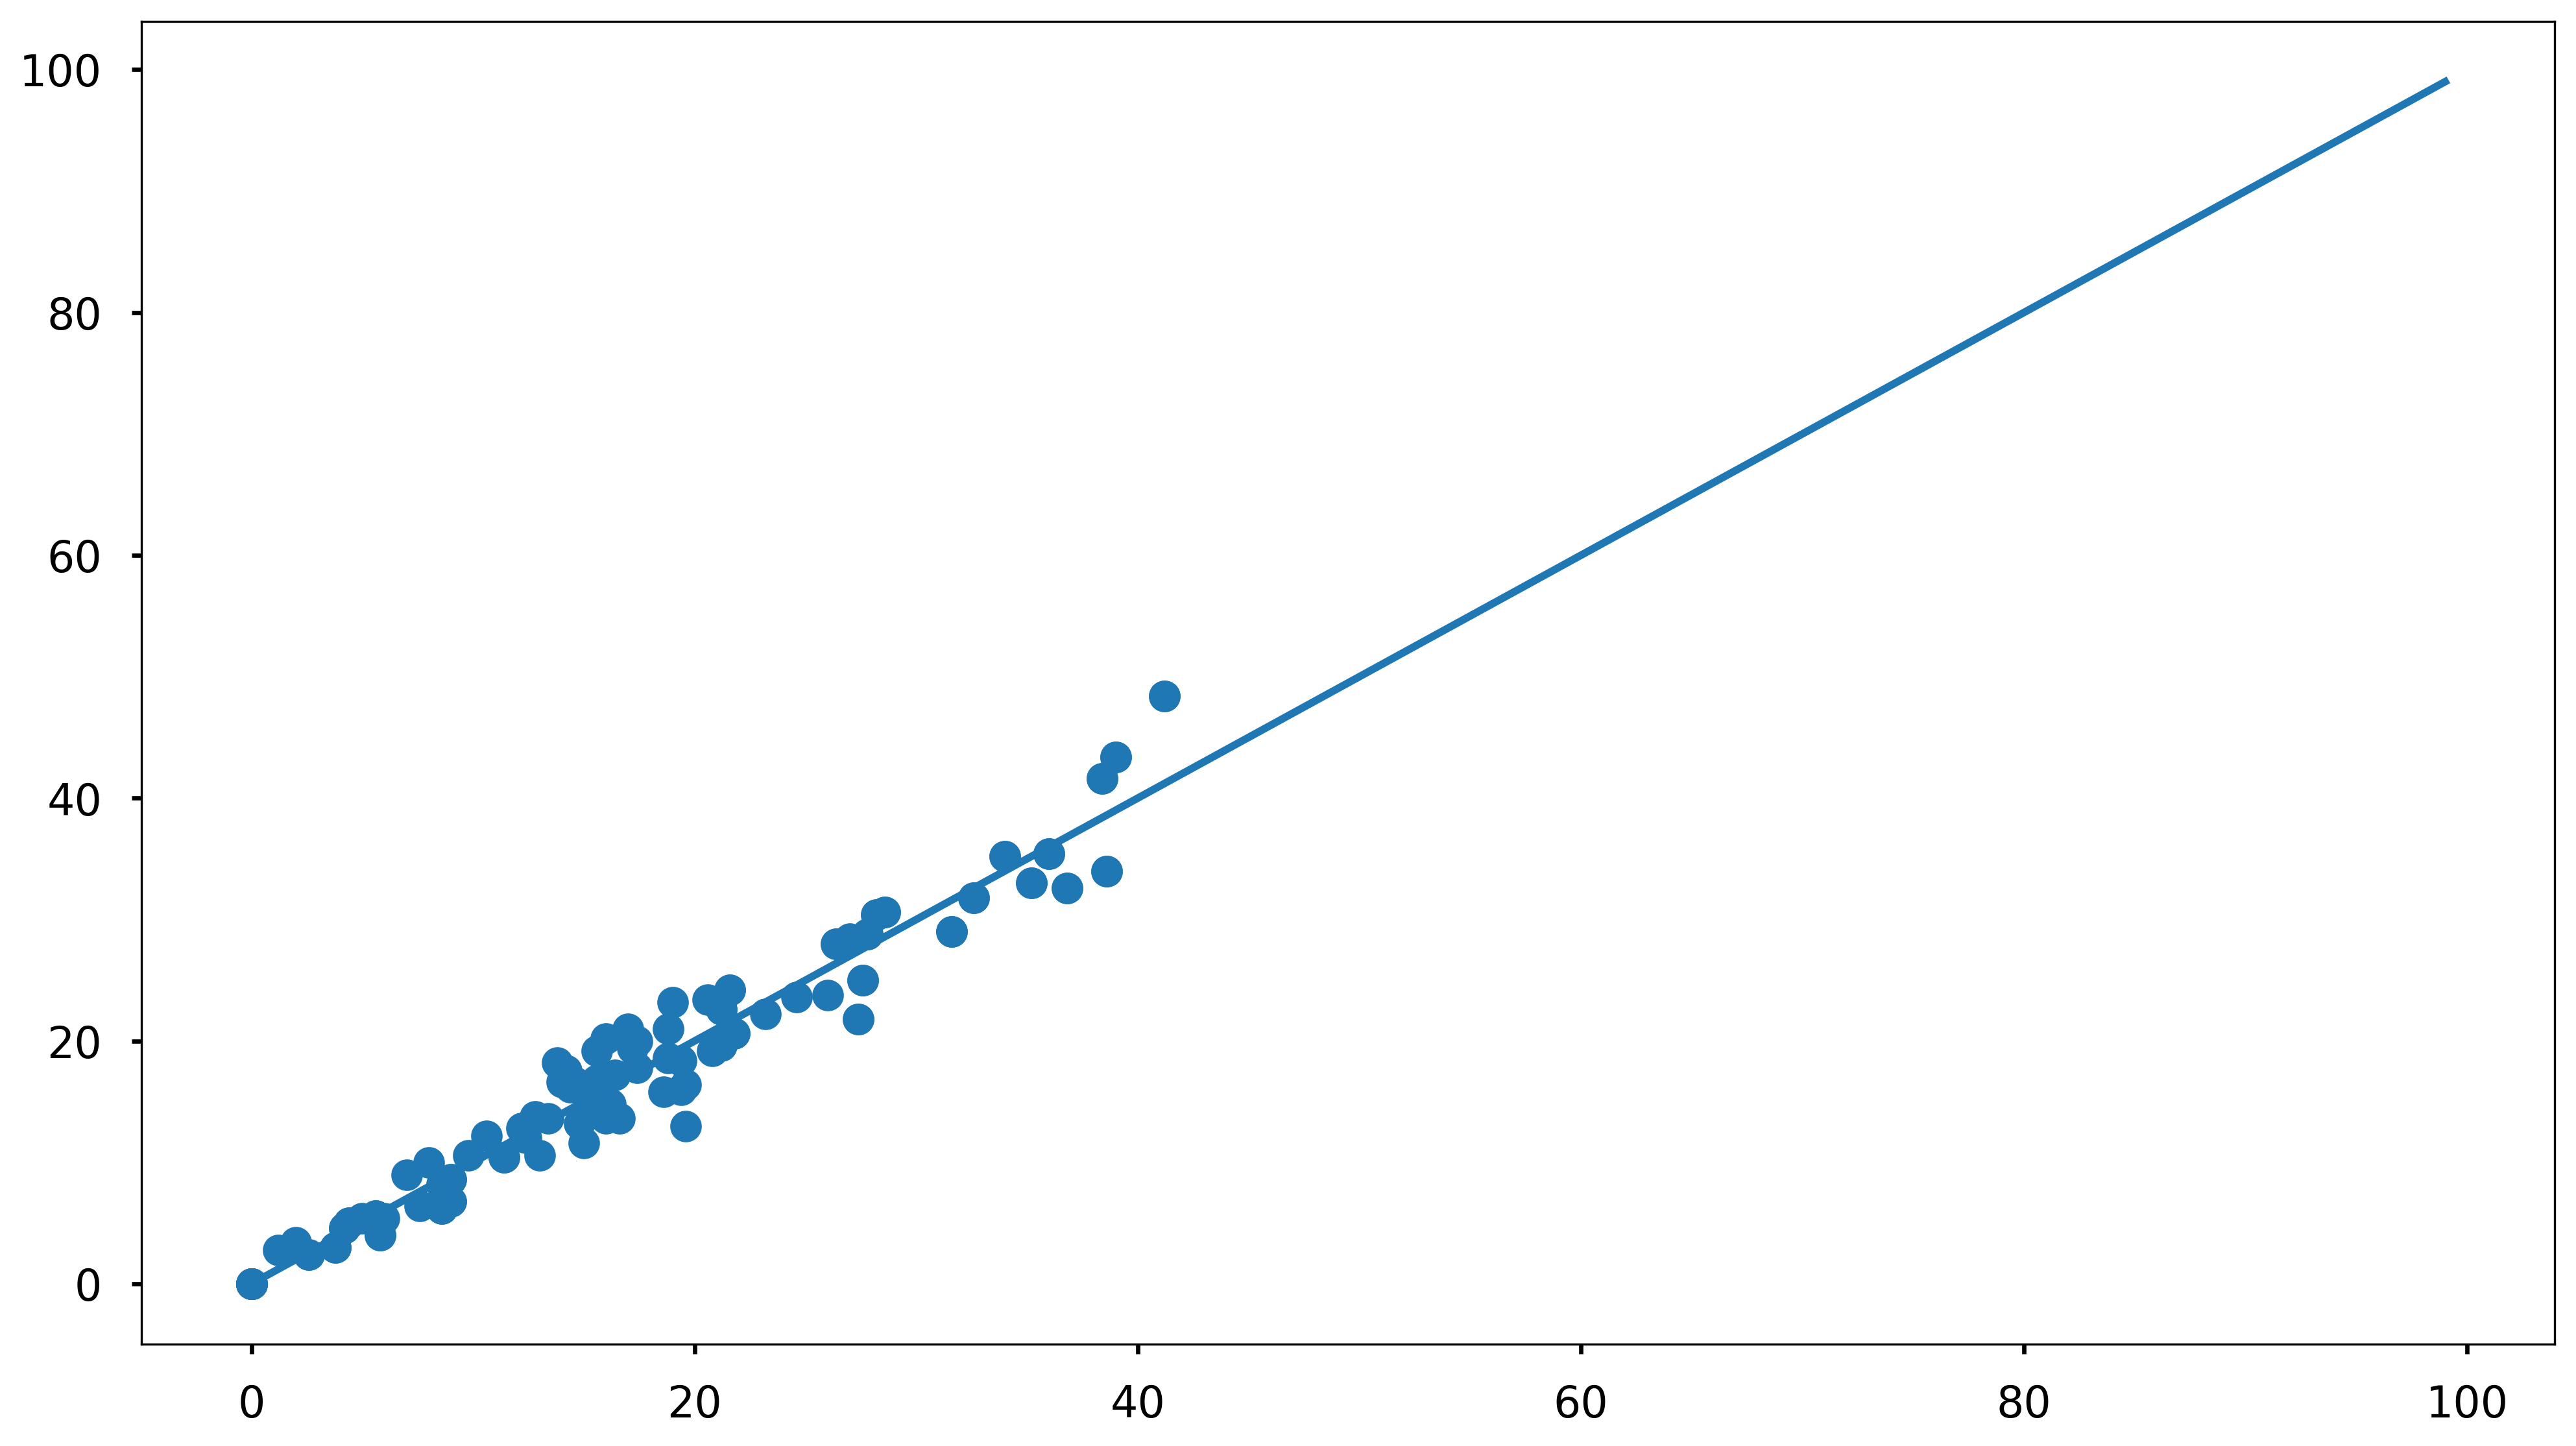

In [37]:
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(x_ee, true_x)
plt.plot(range(100), range(100))
plt.show()

In [38]:
plt.style.use('seaborn-poster')

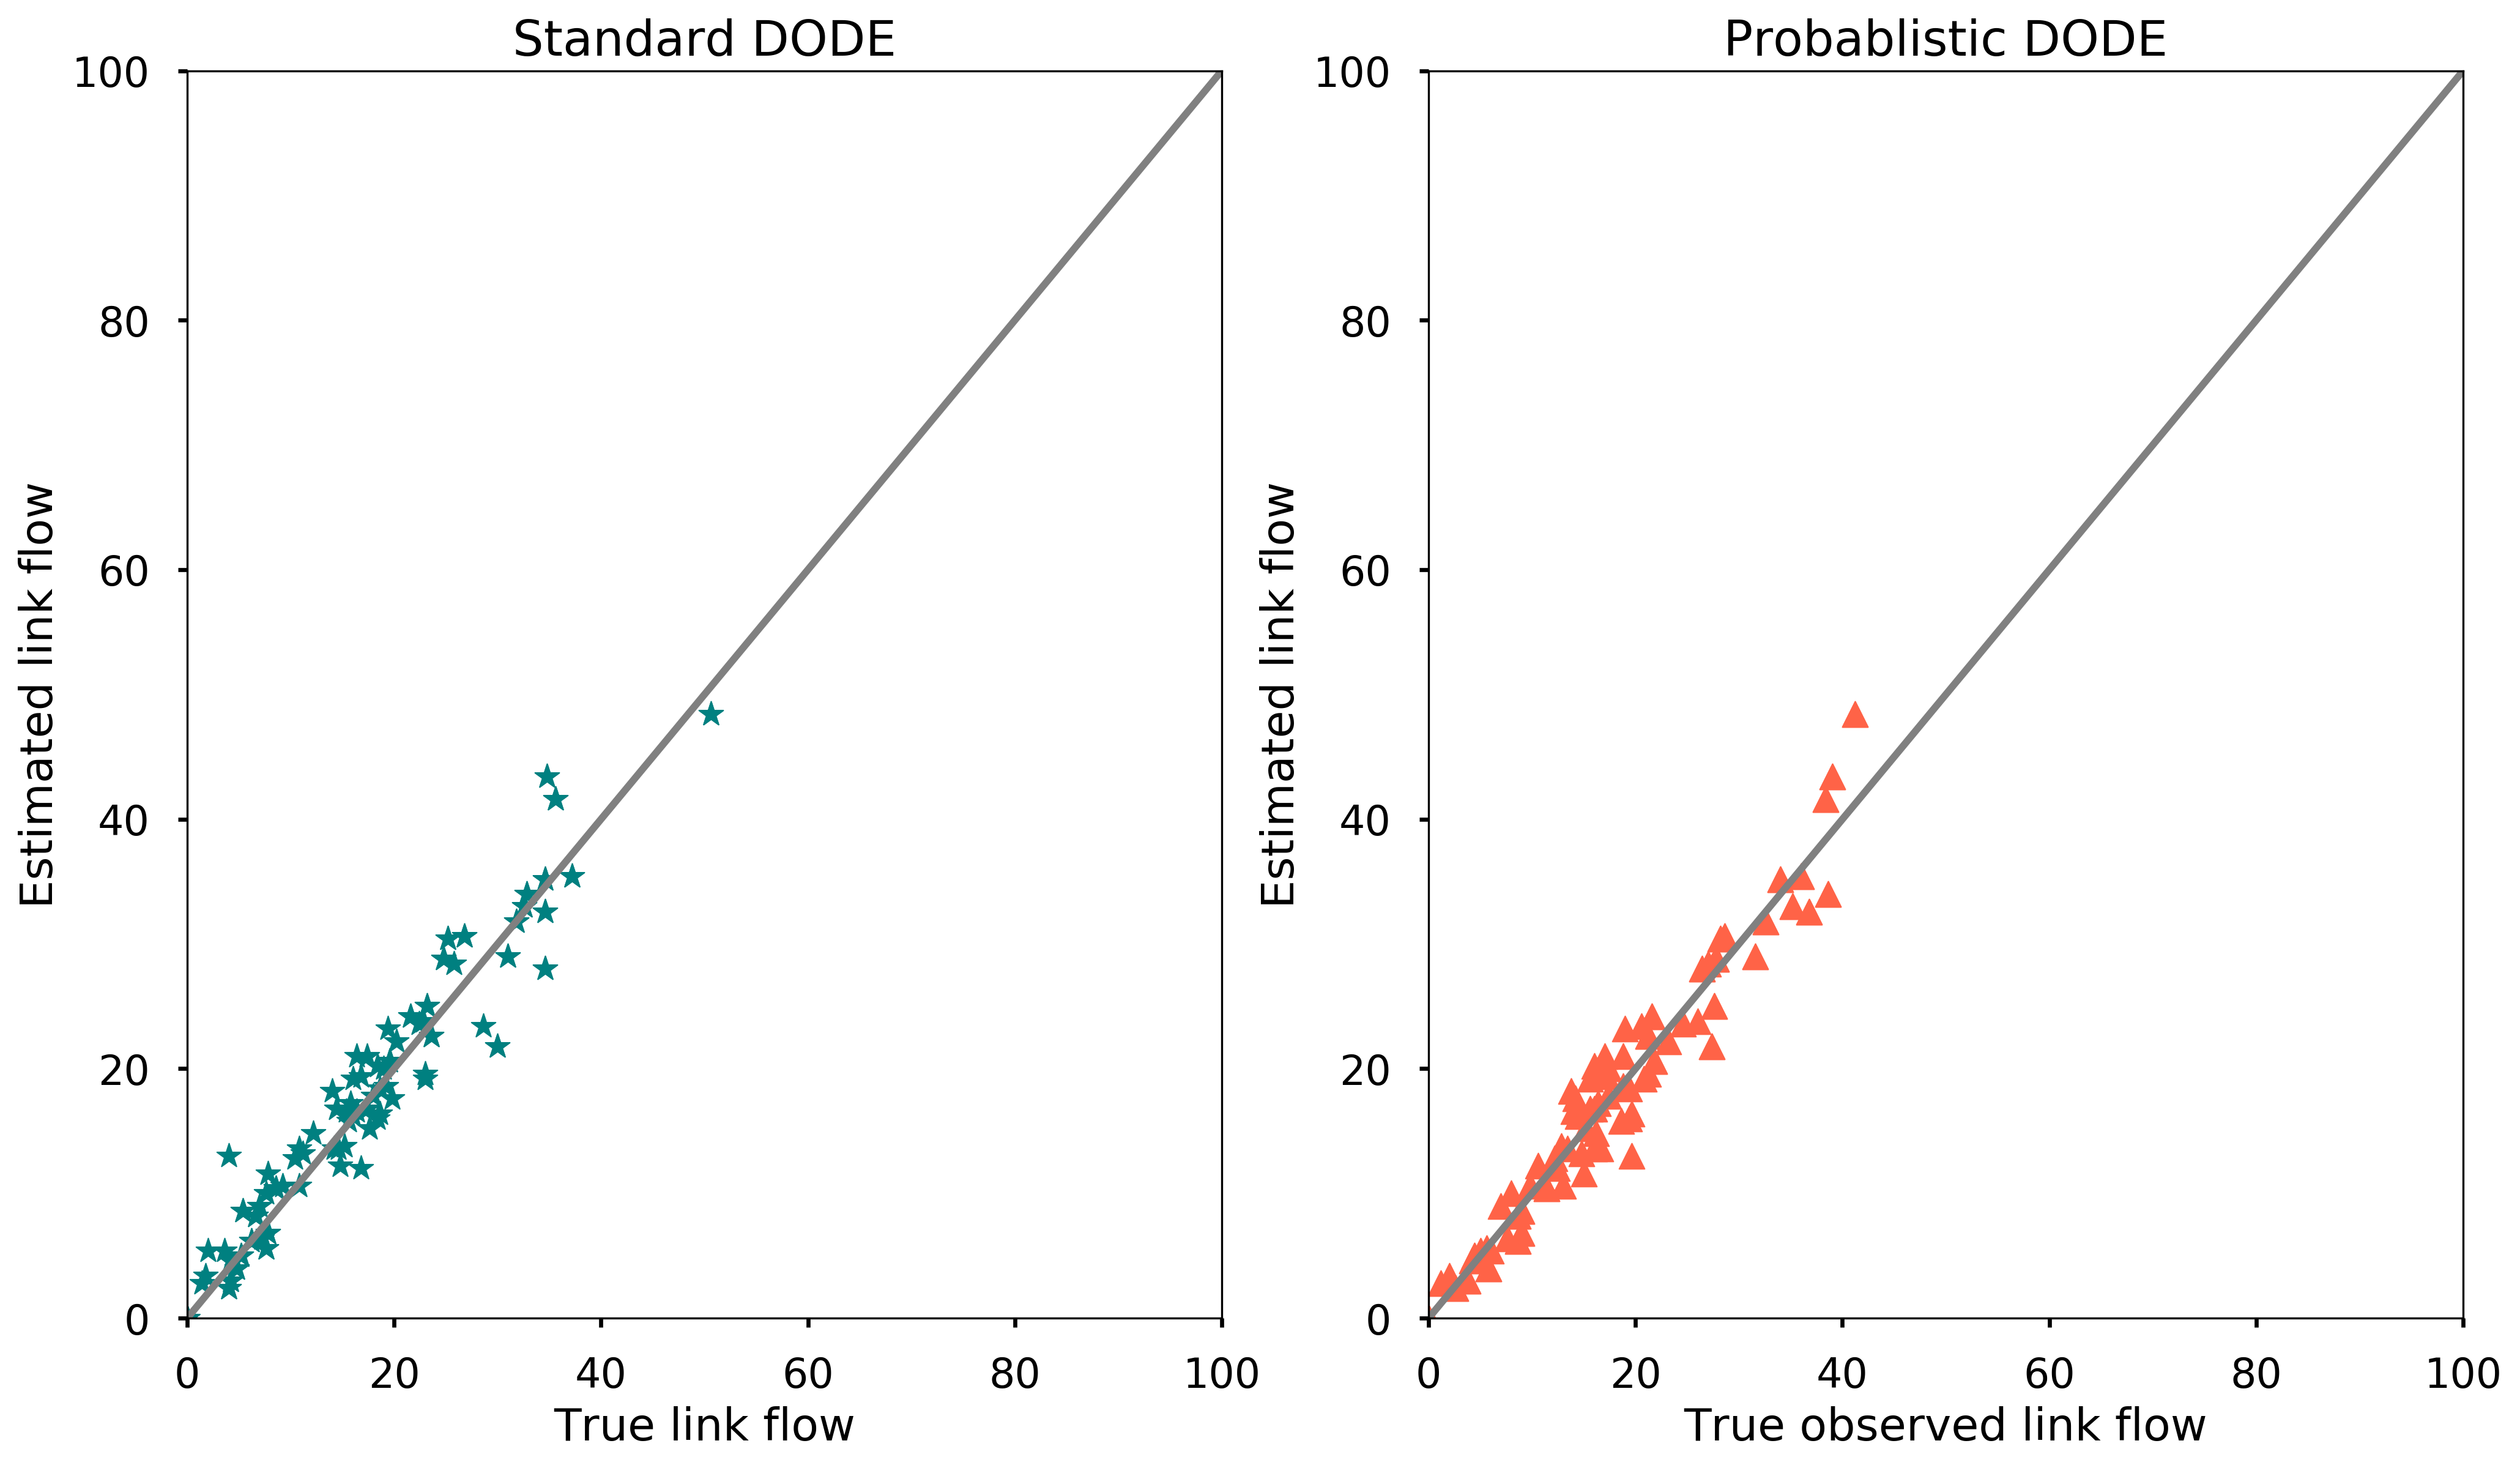

In [39]:
fig, axes = plt.subplots(1,2,  figsize=(16, 9), dpi=300)
# plt.figure(num=None, figsize=(16, 9), dpi=300, facecolor='w', edgecolor='k')
axes[0].scatter(x_e, true_x, label = "Proposed direct solution", color = 'teal', marker = '*', s = 100)
axes[0].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
axes[1].scatter(x_ee, true_x, label = "Proposed closed-form method", color = 'tomato', 
                marker = "^", s = 100)
axes[1].plot(range(350), range(350), label = "Convex optimization solution", color = 'gray')
# axes[1].plot(time_list2, gap_rec2, label = "Quadratic solver method", color = 'tomato')
# plt.ylabel("Equilibrium Gap")
# plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([1, 100])
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_title('Path flow rate (vehs/15-min)')
# axes[1].set_title('Path choice probablity')
axes[0].set_ylabel('Estimated link flow')
axes[0].set_xlabel('True link flow')
axes[1].set_ylabel('Estimated link flow')
axes[1].set_xlabel('True observed link flow')
axes[0].set_xlim([0, 100])
axes[0].set_ylim([0, 100])
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])

axes[0].set_title('Standard DODE')
axes[1].set_title('Probablistic DODE')

plt.show()

In [40]:
np.linalg.norm(x_ee - true_x)

26.51339284210908

In [41]:
np.linalg.norm(x_e - true_x)

32.216765821540804

In [43]:
from sklearn.metrics import r2_score
from scipy import stats
def r2(predictions, targets):
    y_bar = np.mean(targets)
    # diff = np.minimum(np.abs(predictions - targets), targets)
    diff = predictions - targets
    ss_e = np.sum(diff ** 2)
    ss_t = np.sum((targets) ** 2)
    return 1 - ss_e / ss_t

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmsn(predictions, targets):
    return np.sqrt(np.sum((predictions - targets) ** 2) * len(predictions)) / np.sum(targets)

In [44]:
rmsn(x_ee, true_x)

0.13905949761198078

In [45]:
rmsn(x_e, true_x)

0.16897299023574988